In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./Delight/desc-dc2')
from processSEDs import *
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

from delight.io import *
from delight.utils import *
from sklearn.model_selection import train_test_split

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import cost, Minuit

# display iminuit version
import iminuit

%matplotlib inline

In [2]:
fileName='parameters_DESC-DC2.cfg'
conf_file = os.path.realpath(os.path.join('./Delight/desc-dc2/tmp', fileName))
print(conf_file)
params = parseParamFile(conf_file, verbose=False, catFilesNeeded=False)
test_fileout_delight = params['target_catFile']
train_fileout_delight = params['training_catFile']
delight_testFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", 'Delight', 'desc-dc2', test_fileout_delight)))
print('Delight test file:\n\t{}'.format(delight_testFileoutAbs))
delight_trainFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", 'Delight', 'desc-dc2', train_fileout_delight)))

/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/Delight/desc-dc2/tmp/parameters_DESC-DC2.cfg
Delight test file:
	/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/Delight/desc-dc2/tmp/delight_data/test_gal_fluxredshifts.txt


In [3]:
processSEDs(conf_file, bias=True, k=1.0, xmin=200.)

2022-05-03 09:09:12,282 ipykernel_launcher.py, processSEDs[3954] INFO --- Process SED ---


In [4]:
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
sedNamesDelight = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']
fluxredshifts = np.loadtxt(delight_testFileoutAbs)
fluxredshifts_train = np.loadtxt(delight_trainFileoutAbs)
delightUntFac=2.22e10

(7552, 14)


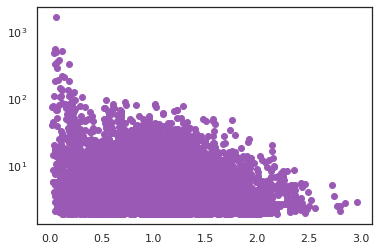

In [5]:
print(fluxredshifts.shape)
fig, ax = plt.subplots(1,1)
ax.scatter(fluxredshifts[:,-2], fluxredshifts[:,0])
ax.set_yscale('log')

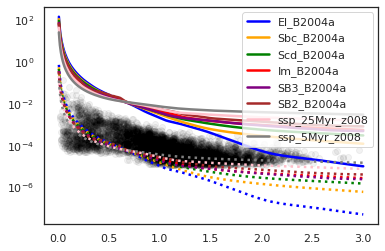

In [6]:
numFilt = 3
fig, ax = plt.subplots(1,1)
for sed, color in zip(np.arange(len(sedNamesDelight)),\
                      ['b', 'orange', 'g', 'r', 'purple', 'brown', 'pink', 'grey']):
    path = os.path.realpath(os.path.join("./", "Delight", "desc-dc2", "tmp", "data", "CWW_SEDs"))
    nameBias = sedNamesDelight[sed] + "_fluxredshiftmod-bias.txt"
    sedDataBias = np.loadtxt(os.path.join(path, nameBias))
    nameReg = sedNamesDelight[sed] + "_fluxredshiftmod.txt"
    sedDataReg = np.loadtxt(os.path.join(path, nameReg))
    ax.plot(redshiftGrid, sedDataBias[:, numFilt], c=color, label=sedNamesDelight[sed])
    ax.plot(redshiftGrid, sedDataReg[:, numFilt], c=color, ls=':')
ax.scatter(fluxredshifts[:, -2], fluxredshifts[:,numFilt*2]/np.sqrt(delightUntFac), alpha=0.05, c='k')
ax.set_yscale('log')
ax.legend()

# Schechter law fit on data

## Load DP0 data:

In [7]:
def convertformatdc2fromrail(h5file):
    """
    convertformatdc2fromrail : access to H5 file from RAIL
    
    input : H5 file descriptor
    output : datasets
    
    """
    u_mag = np.array(h5file.root.photometry.mag_u_lsst)
    g_mag = np.array(h5file.root.photometry.mag_g_lsst)
    r_mag = np.array(h5file.root.photometry.mag_r_lsst)
    i_mag = np.array(h5file.root.photometry.mag_i_lsst)
    z_mag = np.array(h5file.root.photometry.mag_z_lsst)
    y_mag = np.array(h5file.root.photometry.mag_y_lsst)
    u_err = np.array(h5file.root.photometry.mag_err_u_lsst)
    g_err = np.array(h5file.root.photometry.mag_err_g_lsst)
    r_err = np.array(h5file.root.photometry.mag_err_r_lsst)
    i_err = np.array(h5file.root.photometry.mag_err_i_lsst)
    z_err = np.array(h5file.root.photometry.mag_err_z_lsst)
    y_err = np.array(h5file.root.photometry.mag_err_y_lsst)
    z = np.array(h5file.root.photometry.redshift)
    
    
    #Photometry perturbed: doubling sizes of all errors
    #--------------------------------------------------
    u_magn = u_mag + np.sqrt(1)*u_err*np.random.randn(len(u_mag))
    g_magn = g_mag + np.sqrt(1)*g_err*np.random.randn(len(g_mag))
    r_magn = r_mag + np.sqrt(1)*r_err*np.random.randn(len(r_mag))
    i_magn = i_mag + np.sqrt(1)*i_err*np.random.randn(len(i_mag))
    z_magn = z_mag + np.sqrt(1)*z_err*np.random.randn(len(z_mag))
    y_magn = y_mag + np.sqrt(1)*y_err*np.random.randn(len(y_mag))

    
  
    # First: magnitudes only
    data_mags = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag,y_mag))
    
    # err magnitudes only
    data_errmags = np.column_stack((u_err,g_err,r_err,i_err,z_err,y_err))
    

    # Next: colors only
    data_colors = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag))

    # Next: colors and one magnitude
    data_colmag = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag, i_mag))
    perturbed_colmag=np.column_stack((u_magn-g_magn, g_magn-r_magn, r_magn-i_magn, i_magn-z_magn, z_magn-y_magn, i_magn))

    # Finally: colors, magnitude, and size
    #data_colmagsize = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag, i_mag, rad))

    
    data_z = z
    
    return data_mags,  data_errmags, data_colors, data_colmag, perturbed_colmag, data_z

def readfromdp0rsp(h5file):
    """
    convertformatdc2fromdp0rsp : access to H5 file from DP0-RSP
    
    input : H5 file descriptor
    output : datasets
    
    """
    df = pd.read_hdf(h5file,'/photoz')
    return df

m5u = 25.613 #/ 26.100
m5g = 26.678 #/ 27.400
m5r = 26.608 #/ 27.500
m5i = 25.931 #/ 26.800
m5z = 24.732 #/ 26.100
m5y = 23.954 #/ 24.900

def photodet_select(mu,mg,mr,mi,mz,my, UMAX=m5u, GMAX=m5g, RMAX = m5r, IMAX= m5i, ZMAX=m5z, YMAX=m5y):
    return (mu>17) and (mu < UMAX) and (mg < GMAX) and (mr < RMAX) and (mi < IMAX) and (mz < ZMAX) and (my < YMAX)

def selectdc2fromdp0rsp(df, Ntrain=10000,FLAG_APPLYM5CUT = True):
    """
    selectfromdp0rsp : 
    
    input : dataframe
    output : datasets
    
    """
    
    # apply m5 cutoff
    if FLAG_APPLYM5CUT :
        df['selected'] = df.apply(lambda x:  photodet_select(x['mag_u'], x['mag_g'], x['mag_r'], x['mag_i'],x['mag_z'], x['mag_y'] ), axis=1)
        df = df[df["selected"]]
        df = df.drop('selected', axis=1)
        
    df = df.dropna()
    df.reset_index()
    
    Ntot = len(df)
    assert Ntot>Ntrain
    Ntest = Ntot-Ntrain
    
    
    # Test fraction
    test_sample_size_fraction=Ntest/Ntot
    test_sample_size_fraction
    
    
    # split in train/test
    target = df["redshift"]
    features = df[["mag_u","mag_g","mag_r","mag_i","mag_z","mag_y","magerr_u","magerr_g","magerr_r","magerr_i","magerr_z","magerr_y","umg","gmr","rmi","imz","zmy"]]
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)
    return X_train, X_test, y_train, y_test

In [8]:
# DP0 - DC2 extracted from Science Rubin Platform at https://data.lsst.cloud/  
# with  https://github.com/sylvielsstfr/MyDP0LSS/blob/main/09_MLscikitL_PhotoZ_part3.ipynb
inputdatadir2                  = "/sps/lsst/groups/photoz/DC2DP0"
filename_dp0dc2_h5             = "catdp0dc2_photoz_result.h5"
fullfilename_dp0dc2_h5         = os.path.join(inputdatadir2,filename_dp0dc2_h5)  

In [9]:
df = readfromdp0rsp(fullfilename_dp0dc2_h5)
X_train, X_test, y_train, y_test = selectdc2fromdp0rsp(df, FLAG_APPLYM5CUT = False)
#del X_train
#del X_test

In [10]:
y_test.values

array([0.823598, 0.609089, 0.837703, ..., 1.03964 , 1.36322 , 2.57206 ],
      dtype=float32)

In [11]:
X_test

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y,umg,gmr,rmi,imz,zmy
278021,27.852549,26.890676,26.661881,25.678251,25.208412,27.681438,1.545765,0.246468,0.222520,0.179125,0.302033,6.095130,0.961873,0.228795,0.983630,0.469839,-2.473026
208746,26.423766,27.085531,26.102558,25.229972,25.386706,26.039648,0.358980,0.260499,0.108166,0.091461,0.305689,1.197678,-0.661765,0.982973,0.872586,-0.156734,-0.652942
583886,25.487066,25.323991,25.097092,24.103692,23.870271,24.039760,0.195703,0.065571,0.051082,0.042417,0.096091,0.196345,0.163075,0.226899,0.993400,0.233421,-0.169490
210154,24.396403,24.346824,23.727784,22.822986,22.713897,22.593551,0.123279,0.047308,0.029474,0.022853,0.049063,0.083774,0.049579,0.619040,0.904798,0.109090,0.120346
812142,24.422139,24.465586,24.130517,23.636270,23.024999,22.978981,0.083420,0.031950,0.027401,0.033205,0.054696,0.092566,-0.043448,0.335070,0.494247,0.611271,0.046018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490169,27.470049,26.184164,26.207856,25.264453,25.019661,24.631216,0.879424,0.116519,0.135432,0.100589,0.239541,0.333228,1.285885,-0.023692,0.943403,0.244793,0.388444
350923,27.130371,27.949466,26.665056,26.011604,25.209435,24.765865,0.640562,0.588972,0.180295,0.184421,0.243109,0.379502,-0.819095,1.284410,0.653453,0.802168,0.443570
688470,21.741067,21.825504,21.625321,21.242074,20.524397,20.316609,0.010514,0.003841,0.003398,0.004230,0.006446,0.008848,-0.084437,0.200183,0.383247,0.717676,0.207789
371335,25.117891,24.680286,24.559053,23.940573,23.608534,22.977935,0.114054,0.033117,0.030197,0.032114,0.064642,0.071638,0.437605,0.121232,0.618480,0.332040,0.630599


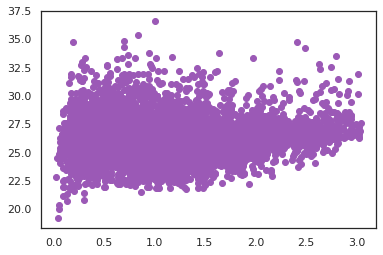

In [12]:
plt.scatter(y_train.values,X_train["mag_u"].values)

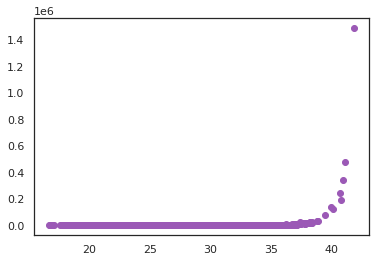

In [13]:
plt.scatter(X_test["mag_u"].values, X_test["magerr_u"].values)

In [14]:
mag_inf, mag_sup = 17.0, 18.0
nbGal = len([x for x in X_test["mag_r"].values if (x >= mag_inf and x < mag_sup) ])

In [15]:
print(nbGal)

184


In [16]:
mag_bins = np.linspace(np.min(X_test["mag_r"].values), np.max(X_test["mag_r"].values), 100)
nbGalArray = np.array([], dtype=int)
nbTot = 0
for mag_inf, mag_sup in zip(mag_bins[0:-1], mag_bins[1:]):
    nbGal = len([x for x in X_test["mag_r"].values if (x >= mag_inf and x < mag_sup) ])
    #print(mag_inf, mag_sup, nbGal)
    nbTot += nbGal
    nbGalArray = np.append(nbGalArray, nbGal)
nbGalArray

array([    1,     1,     1,     1,     0,     2,     1,     3,     2,
           1,     3,     3,     6,    12,    11,    11,    14,    18,
          20,    27,    25,    45,    44,    46,    69,    84,   110,
         126,   173,   187,   218,   241,   278,   354,   431,   487,
         537,   619,   707,   844,   979,  1125,  1328,  1508,  1695,
        2029,  2251,  2809,  3256,  4014,  4631,  5274,  6098,  6767,
        7644,  8351,  9276, 10405, 11620, 12753, 14183, 15634, 18743,
       22008, 24166, 27151, 30938, 33971, 38204, 42683, 47103, 51908,
       55365, 57658, 60531, 61315, 58729, 53728, 46386, 31907, 19793,
       13993,  9620,  6718,  4553,  2941,  1925,  1318,   846,   523,
         385,   245,   171,   107,    86,    56,    24,    19,    17])

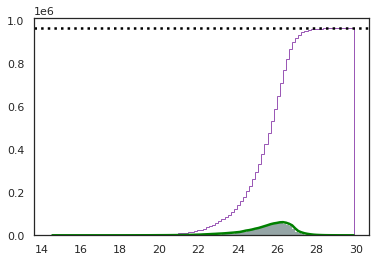

In [17]:
plt.hist(X_test["mag_r"].values, bins=mag_bins, cumulative=True, histtype='step')
plt.hist(X_test["mag_r"].values, bins=mag_bins, cumulative=False, histtype='stepfilled')
plt.axhline(nbTot, c='k', ls=":")
plt.plot(mag_bins[1:],nbGalArray, c="g")

In [18]:
phistar=0.006
mstar=18
alpha=-1.5
k=alpha+1
m5cut=26.2
m5width=0.7
phi = lambda m : 0.4*np.log(10)*phistar * \
                np.power(10, -0.4*(alpha+1.)*(m - mstar)) * \
                np.exp(-np.power(10, -0.4*(m - mstar))) * \
                erfc((m-m5cut)/m5width)
print(phi(0.5*(mag_bins[:-1] + mag_bins[1:])))

[1.81751786e-14 5.98712353e-13 1.24608895e-11 1.74269682e-10
 1.72742292e-09 1.27096748e-08 7.22426452e-08 3.28406203e-07
 1.23028489e-06 3.89805881e-06 1.06831439e-05 2.58230855e-05
 5.59876603e-05 1.10480809e-04 2.00944936e-04 3.40574764e-04
 5.43006944e-04 8.21138657e-04 1.18612051e-03 1.64668968e-03
 2.20890305e-03 2.87623756e-03 3.64996619e-03 4.52969809e-03
 5.51397844e-03 6.60086813e-03 7.78845186e-03 9.07524938e-03
 1.04605248e-02 1.19445018e-02 1.35285000e-02 1.52150099e-02
 1.70077234e-02 1.89115357e-02 2.09325303e-02 2.30779569e-02
 2.53562095e-02 2.77768088e-02 3.03503936e-02 3.30887210e-02
 3.60046789e-02 3.91123089e-02 4.24268415e-02 4.59647426e-02
 4.97437709e-02 5.37830471e-02 5.81031332e-02 6.27261230e-02
 6.76757429e-02 7.29774644e-02 7.86586264e-02 8.47485701e-02
 9.12787846e-02 9.82830657e-02 1.05797687e-01 1.13861584e-01
 1.22516555e-01 1.31807474e-01 1.41782520e-01 1.52493410e-01
 1.63995603e-01 1.76348299e-01 1.89613690e-01 2.03853727e-01
 2.19119942e-01 2.354264

[   4   53   69   87  104  114  165  177  181  184  198  229  233  243
  247  248  271  281  293  315  318  343  354  362  383  403  409  441
  445  456  461  462  469  473  520  543  548  556  563  573  602  611
  619  622  627  630  640  648  658  662  666  696  700  703  706  707
  737  752  774  775  813  825  852  855  901  918  925  930  937  944
  951  955  979  983  997  999 1006 1038 1101 1115 1141 1164 1165 1172
 1197 1199 1216 1217 1250 1297 1299 1318 1325 1326 1335 1338 1355 1384
 1395 1400 1406 1416 1441 1466 1467 1499 1500 1501 1509 1511 1514 1536
 1559 1561 1563 1580 1585 1590 1600 1612 1613 1642 1643 1663 1668 1697
 1724 1726 1732 1737 1757 1761 1763 1765 1766 1767 1775 1799 1805 1822
 1831 1860 1866 1885 1888 1892 1939 1963 1990 2017 2023 2027 2058 2066
 2076 2095 2108 2111 2131 2142 2172 2189 2204 2207 2231 2295 2298 2341
 2359 2371 2385 2388 2399 2436 2442 2446 2456 2474 2493 2524 2542 2543
 2552 2553 2561 2564 2568 2581 2601 2651 2669 2690 2704 2762 2787 2825
 2849 

[]

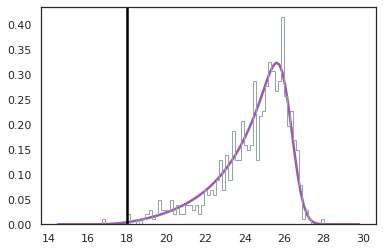

In [21]:
plt.plot(0.5*(mag_bins[:-1] + mag_bins[1:]), phi(0.5*(mag_bins[:-1] + mag_bins[1:])))
sel = np.where(np.logical_and(y_train >= 0, y_train < 1/3))[0]
print(sel)
plt.hist(X_train["mag_r"].values[sel], bins=mag_bins, cumulative=False, histtype='step', density=True)
plt.axvline(mstar, color='k')
plt.plot()

In [20]:
def DistLumFuncModel(x, A ,alpha, m_star, m5cut,m5width):
    """
    Luminosity distribution function wrt x = magnotude
     
    input arg :
      - x : magnitude
      - A : global normalisation factio
      - alpha : exponent
      - m_star :
     
    func_model = 0.4 ln(10) 10^{-0.4(alpha+1)(m-m_star)} exp(-10^{-0.4*(m-m_star)}) 
    
    the func_model is multiplied by the erfc function to include a model of cutoff
    
    """
    m = x
    func_model = A * 0.4 * np.log(10)*np.exp(-0.4*(alpha+1)*(m-m_star)*np.log(10)) * \
            np.exp(-np.exp(-0.4*(m-m_star)*np.log(10)))*special.erfc((m-m5cut)/m5width)
    return func_model